In [1]:
import sys; sys.path.append('../')

from src.data_loader import load_data
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
import numpy as np

import warnings
warnings.filterwarnings('ignore')

/home/nicolas/.local/share/virtualenvs/point-cloud-learn-qCE1QqFz/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/nicolas/.local/share/virtualenvs/point-cloud-learn-qCE1QqFz/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
plt.rcParams["figure.figsize"] = (10,10)

# Analysis of the final datasets of clusters

In [16]:
clusters, _ = load_data('../data/all_clusters.txt')
clusters = clusters.drop(
    ['file_origin', 'file_destination', 'confidence', 'texture_code_origin', 'texture_code_destination'],
    axis=1
)

In [19]:
data = clusters.replace('None', np.nan).dropna(axis=1)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = data.select_dtypes(include=numerics).columns

## Some numbers:

- Number of instances: 5958
- Number of features: 55
- Number of usable features (at least one not null): 42
- Number of numerical features: 40

In [5]:
data.describe()

,x,y,z,n_points,n_order,volume,positive_volume,negative_volume,area,confidence,...,coplanararity_index_mean_origin,coplanararity_index_sigma_origin,colinearity_index_mean_origin,colinearity_index_sigma_origin,coplanararity_index_mean_destination,coplanararity_index_sigma_destination,colinearity_index_mean_destination,colinearity_index_sigma_destination,angles_mean,angles_sigma
count,5979.000000,5979.000000,5979.000000,5979.000000,5979.000000,5979.000000,5979.000000,5979.000000,5979.000000,5979.0,...,5979.000000,5979.000000,5979.000000,5979.000000,5979.000000,5979.000000,5979.000000,5979.000000,5979.000000,5979.000000
mean,12.757737,229.207468,33.075939,16285.346881,52.209734,0.081435,0.033602,0.047833,0.134041,100.0,...,1.966798,0.291773,0.819152,0.820648,2.095133,0.319680,0.803430,0.794070,0.359606,0.191353
std,36.836496,28.191641,31.040965,9029.453401,153.771960,0.273939,0.138257,0.156315,0.381871,0.0,...,0.990350,0.154994,0.972517,1.596151,1.002472,0.173717,0.947667,1.782855,0.297108,0.146987
min,-56.002600,177.373485,-24.307235,16.000000,10.000000,0.000627,0.000000,0.000000,0.000018,100.0,...,0.419699,0.022959,0.006282,0.001521,0.509398,0.012059,0.006961,0.003005,0.003637,0.002340
25%,-20.151222,205.781692,6.815408,8529.000000,13.000000,0.008542,0.001030,0.002885,0.021705,100.0,...,1.237358,0.189115,0.193439,0.097941,1.350372,0.203378,0.202744,0.096949,0.105173,0.052529
50%,12.334667,225.207400,31.279300,16341.000000,20.000000,0.022001,0.005776,0.011255,0.051830,100.0,...,1.665279,0.261149,0.525453,0.325043,1.783235,0.288855,0.551279,0.339977,0.291761,0.166815
75%,45.017658,250.411658,54.647757,24212.500000,40.000000,0.060107,0.023422,0.035237,0.120660,100.0,...,2.477367,0.353180,1.078760,0.922781,2.607537,0.395414,1.067778,0.872303,0.545516,0.313315
max,87.307455,320.017000,110.874583,31700.000000,4702.000000,9.045179,5.182637,3.862542,13.373500,100.0,...,6.388965,1.952617,13.737160,40.191173,6.282414,2.044650,19.310895,54.604309,1.532109,0.662483


## Objective variable distribution

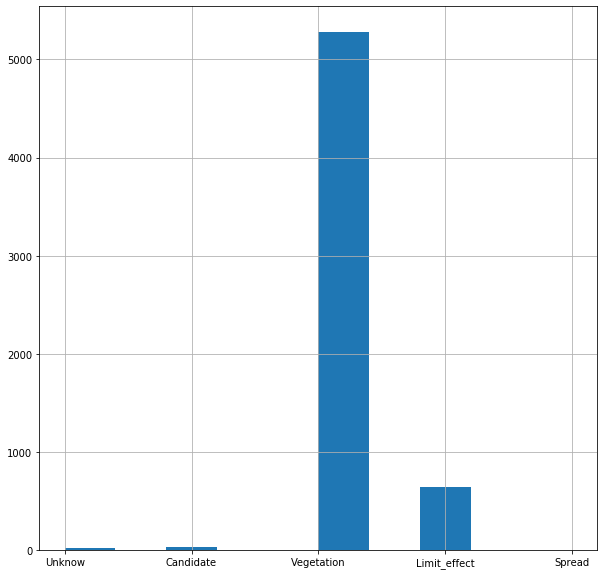

In [6]:
clusters.classification.hist()

As we can see we are handling a highly unbalanced dataset, having more than 95% of the instances not belonging to the interesting variable, Candidate or Spread.

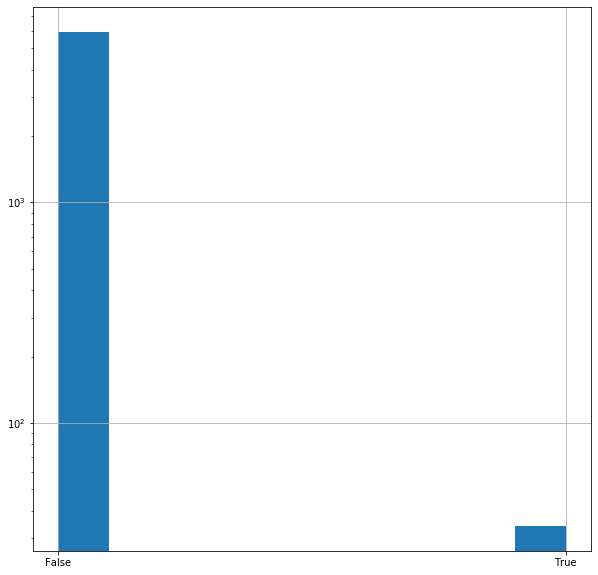

In [14]:
plt.yscale('log')
((clusters.classification == 'Candidate') | (clusters.classification == 'Spread')).astype(str).hist()

In [15]:
((clusters.classification == 'Candidate') | (clusters.classification == 'Spread')).value_counts()

False    5945
True       34
Name: classification, dtype: int64

In [20]:
correlations = np.zeros((len(numerical_columns), len(numerical_columns)))

for i1, c1 in enumerate(numerical_columns):
    for i2, c2 in enumerate(numerical_columns):
        correlations[i1, i2] = np.abs(pearsonr(data[c1], data[c2])[0])

## Pearson correlation coefficient among numerical variables

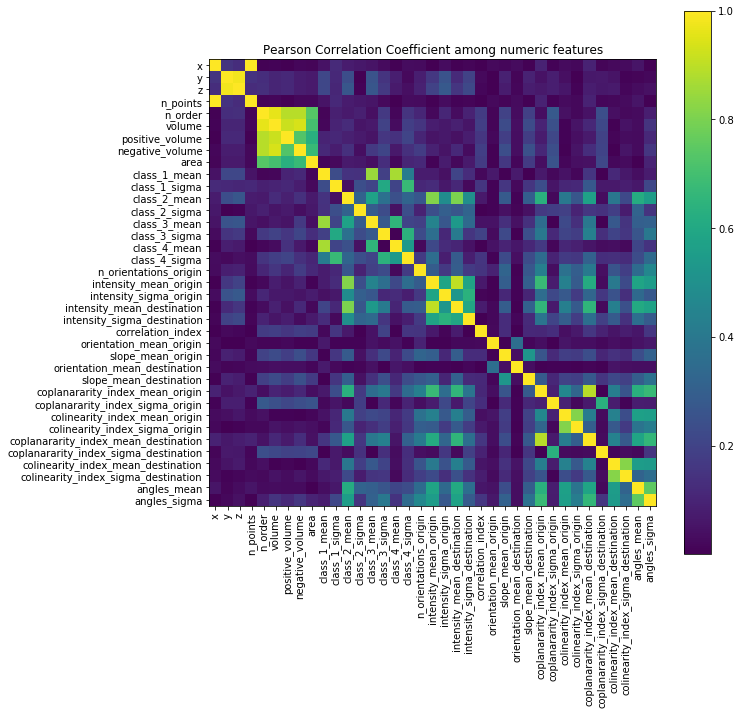

In [21]:
fig, ax = plt.subplots()
im = ax.imshow(correlations, interpolation='nearest')

ax.set_title('Pearson Correlation Coefficient among numeric features')

plt.xticks(np.arange(len(numerical_columns)), numerical_columns, rotation='vertical')
plt.yticks(np.arange(len(numerical_columns)), numerical_columns)

ax.figure.colorbar(im, ax=ax)

There are several variables that are highly related, the features that are mean and standard deviation for example. Some variables have the same value always as confidence.

## Point biserial correlation among continous variables and correlation as Veg/~Veg

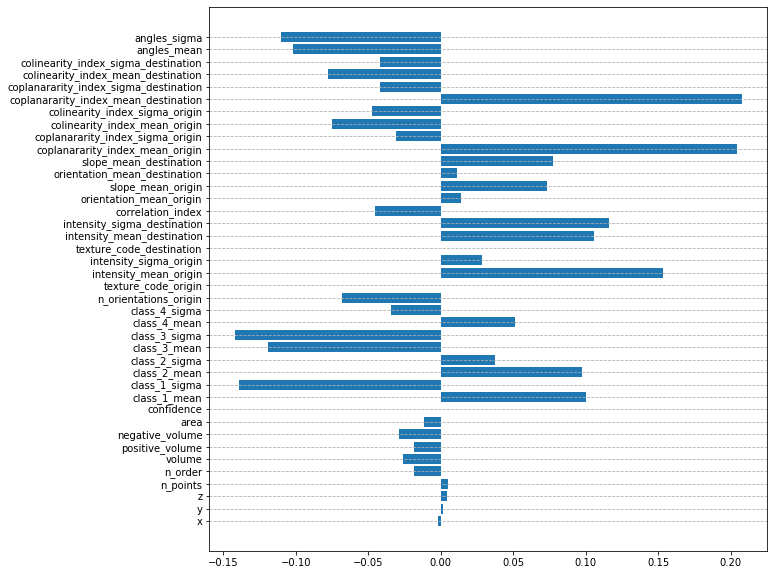

In [9]:
from scipy.stats import pointbiserialr

binary_class = ((clusters['classification'] != 'Vegetation') & (clusters['classification'] != 'Limit_effect'))

correlations = np.zeros(len(numerical_columns))

for i, col in enumerate(numerical_columns):
    correlations[i] = pointbiserialr(data[col], binary_class)[0]
    
correlations[np.isnan(correlations)] = 0
plt.figure()
plt.barh(range(len(correlations)), correlations,align='center')
plt.yticks(np.arange(len(numerical_columns)), numerical_columns)
plt.grid(axis='y', linestyle='--')
pass

In [10]:
np.array(numerical_columns)[np.where(correlations > 0)]

array(['y', 'z', 'n_points', 'class_1_mean', 'class_2_mean',
       'class_2_sigma', 'class_4_mean', 'intensity_mean_origin',
       'intensity_sigma_origin', 'intensity_mean_destination',
       'intensity_sigma_destination', 'orientation_mean_origin',
       'slope_mean_origin', 'orientation_mean_destination',
       'slope_mean_destination', 'coplanararity_index_mean_origin',
       'coplanararity_index_mean_destination'], dtype=object)

## PCA

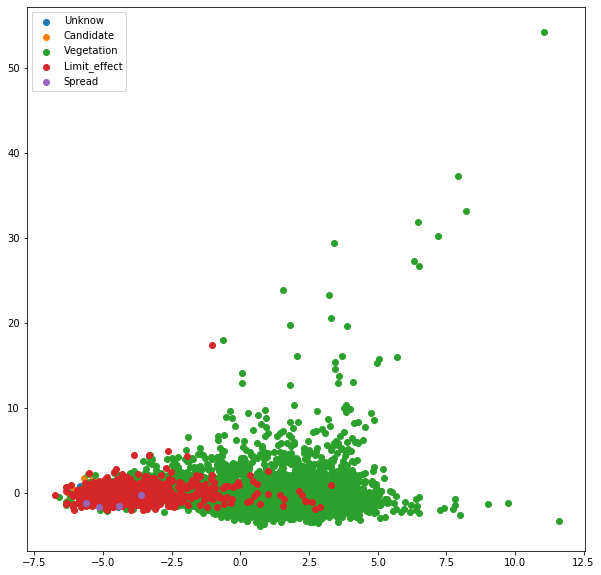

In [24]:
from sklearn.decomposition import PCA


X = data[numerical_columns]
X = (X - X.mean()) / X.std()
y = data['classification']

pca = PCA(n_components=2)
transformed_data = pca.fit_transform(X)

fig, ax = plt.subplots()
for classification in y.unique():
    ax.scatter(*transformed_data[y == classification].T, label=classification)
plt.legend()

## PCA Binary

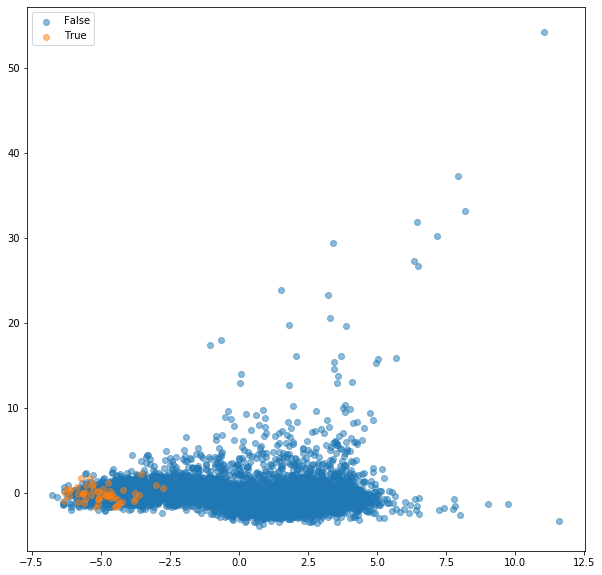

In [26]:
y = ((data['classification'] != 'Vegetation') & (data['classification'] != 'Limit_effect'))

fig, ax = plt.subplots()
for classification in y.unique()[::-1]:
    ax.scatter(*transformed_data[y == classification].T, label=classification, alpha=0.5)
plt.legend()

## MDS Binary

In [13]:
from sklearn.manifold import MDS


X = data[numerical_columns].drop(
    ['confidence', 'texture_code_origin', 'texture_code_destination'],
    axis=1
)
X = (X - X.mean()) / X.std()
y = ((data['classification'] == 'Vegetation') | (data['classification'] == 'Limit_effect'))

mds = MDS(n_components=2, n_jobs=-1)
transformed_data = mds.fit_transform(X)

fig, ax = plt.subplots()
for classification in y.unique():
    ax.scatter(*transformed_data[y == classification].T, label=classification)
plt.legend()

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots()
for classification in y.unique():
    ax.scatter(*transformed_data[cropped_y == classification].T, label=classification)
plt.xlim()

plt.xlim( (min(transformed_data[cropped_y == False][:, 0]),max(transformed_data[cropped_y == False][:, 0])))
plt.ylim( (min(transformed_data[cropped_y == False][:, 1]),max(transformed_data[cropped_y == False][:, 1])))

## TSNE Binary

In [ ]:
from sklearn.manifold import TSNE


X = data[numerical_columns].drop(
    ['confidence', 'texture_code_origin', 'texture_code_destination'],
    axis=1
)
X = (X - X.mean()) / X.std()
y = data['classification']

tsne = TSNE(n_components=2)
transformed_data = tsne.fit_transform(X)

fig, ax = plt.subplots()
for classification in y.unique():
    ax.scatter(*transformed_data[y == classification].T, label=classification)
plt.legend()

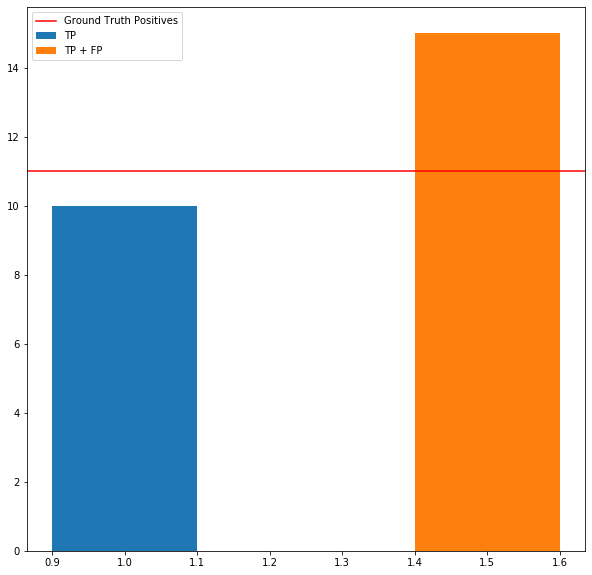

In [37]:
plt.bar([1], [10], width=0.2, label='TP')
plt.bar([1.5], [15], width=0.2, label='TP + FP')
plt.axhline(11, color='r', label='Ground Truth Positives')
plt.legend()